In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [85]:
df = pd.read_csv('../data/qm9-shape-properties', sep=' ', 
    names='dbid dipole polarizability homo lumo gap extent zpve internalzero internalfinite enthalpy freeenergy heatcap volume area'.split())

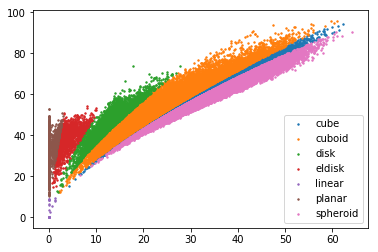

In [87]:
df['shape'] = df.apply(lambda row: classify(row.volume, row.area), axis=1)
for name, group in df.groupby('shape'):
    plt.scatter(group.volume, group.area, s=2, label=name)
plt.legend()

In [4]:
def classify(volume, area):    
    def spheroid(xs, ratio):
        e = 1-1/ratio**2
        return 2*np.pi*(3*xs/(4*np.pi*ratio))**(2/3)*(1+ratio/np.sqrt(e) * np.arcsin(np.sqrt(e)))

    def cuboid(xs, px, py):
        return 2*(px+py+px*py)*(xs/(px*py))**(2/3)

    def disk(xs, ratio):
        return 2*np.pi*(xs*ratio/np.pi)**(2/3)*(1+1/ratio)

    def vertical(xs, limit):
        return [0] + [limit] * (len(xs)-1)

    def eldisk(xs, px, py):
        h = (1-px)**2/(1+px)**2
        q = 2*np.pi*px + py*np.pi*(1+px)*(1+3*h/(10+np.sqrt(4-3*h)))
        return (xs/(np.pi*px*py))**(2/3)*q
    
    def sphere(xs):
        return (6*xs)**(2/3)*(np.pi)**(1/3)
    
    def cube(xs):
        return 6*(xs)**(2/3)
    
    if volume < 10 and area < 10:
        return 'linear'
    
    borders = np.array([eldisk(volume, 25, 0.2),eldisk(volume, 8, 0.2), eldisk(volume, 1.5, 0.2), disk(volume, 5), disk(volume, 3),cuboid(volume, 1, 5), cuboid(volume, 1, 2), cube(volume), spheroid(volume, 3), spheroid(volume, 1.5), sphere(volume)])
    labels = np.array(['planar', 'eldisk', 'eldisk', 'disk', 'disk', 'cuboid', 'cuboid', 'cube', 'spheroid', 'spheroid', 'sphere'])
        
    return labels[np.argmin(np.abs(borders - area))]

In [91]:
def stepify(hist, bins):
    return np.array([0] + list(np.repeat(hist, 2)) + [0]), np.repeat(bins, 2)
def plot_into_count(ax, column, targetshape, nbins=50):
    nbins = 50
    colrange = (min(df[column]), max(df[column]))
    baselinecount, bins = np.histogram(df[column], bins=nbins, range=colrange, density=False)
    baselineplotcount, baselineplotbins = stepify(baselinecount, bins)

    for name, group in df.groupby('shape'):
        if name != targetshape:
            continue
        groupcount, bins = np.histogram(group[column], bins=nbins, range=colrange, density=False)

        # add CI
        p = baselinecount/sum(baselinecount)
        n = sum(groupcount)
        sigma = np.sqrt(n*p*(1-p))

        delta = groupcount-sum(groupcount)*baselinecount/sum(baselinecount)
        
        mask = np.abs(delta) < 3*sigma
        delta *= 100/sum(groupcount)
        
        visdelta, _ = stepify(delta, bins)
        ax.plot(baselineplotbins, visdelta, label=name, alpha=0.3, color='#1f77b4')
        
        delta[mask] = np.nan
        visdelta, _ = stepify(delta, bins)
        ax.plot(baselineplotbins, visdelta, label=name, color='#1f77b4')

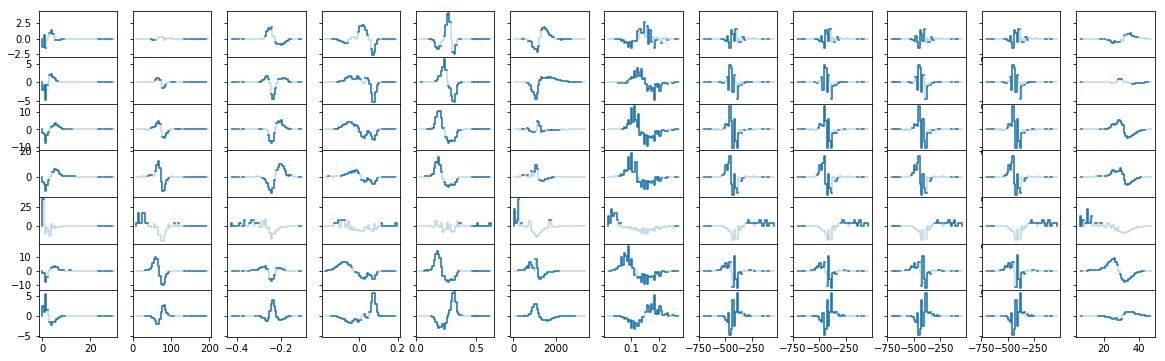

In [94]:
relevant_properties = 'dipole polarizability homo lumo gap extent zpve internalzero internalfinite enthalpy freeenergy heatcap'.split()
relevant_shapes = 'cube cuboid disk eldisk linear planar spheroid'.split()
f, axs = plt.subplots(len(relevant_shapes), len(relevant_properties), figsize=(20, 6), sharex='col', sharey='row')
for shapeid, shape in enumerate(relevant_shapes):
    for propertyid, propertyvalue in enumerate(relevant_properties):
        plot_into_count(axs[shapeid, propertyid], propertyvalue, shape)
plt.subplots_adjust(wspace=0.2, hspace=0.0)